In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

In [3]:
df = sns.load_dataset('flights')
print(df.head())
# we get only year and month for date but we need day also


   year month  passengers
0  1949   Jan         112
1  1949   Feb         118
2  1949   Mar         132
3  1949   Apr         129
4  1949   May         121


- converting the date to YYYY-MM-DD format in a new column named yearMonth
- this should always be the first thing while dealing with time series that is if given dates are not in format of YYYY-MM-DD than format it

In [5]:
df['yearMonth'] = "01-" + df['month'].astype('str') + "-" + df['year'].astype('str')

In [6]:
df.head()

,year,month,passengers,yearMonth
0,1949,Jan,112,01-Jan-1949
1,1949,Feb,118,01-Feb-1949
2,1949,Mar,132,01-Mar-1949
3,1949,Apr,129,01-Apr-1949
4,1949,May,121,01-May-1949


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
 3   yearMonth   144 non-null    object  
dtypes: category(1), int64(2), object(1)
memory usage: 4.0+ KB


In [8]:
df['yearMonth'] = pd.to_datetime(df['yearMonth'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   year        144 non-null    int64         
 1   month       144 non-null    category      
 2   passengers  144 non-null    int64         
 3   yearMonth   144 non-null    datetime64[ns]
dtypes: category(1), datetime64[ns](1), int64(2)
memory usage: 4.0 KB


In [10]:
# make yearMonth column as index of the dataframe
df = df.set_index('yearMonth')
df.head()

,year,month,passengers
yearMonth,,,
1949-01-01,1949,Jan,112
1949-02-01,1949,Feb,118
1949-03-01,1949,Mar,132
1949-04-01,1949,Apr,129
1949-05-01,1949,May,121


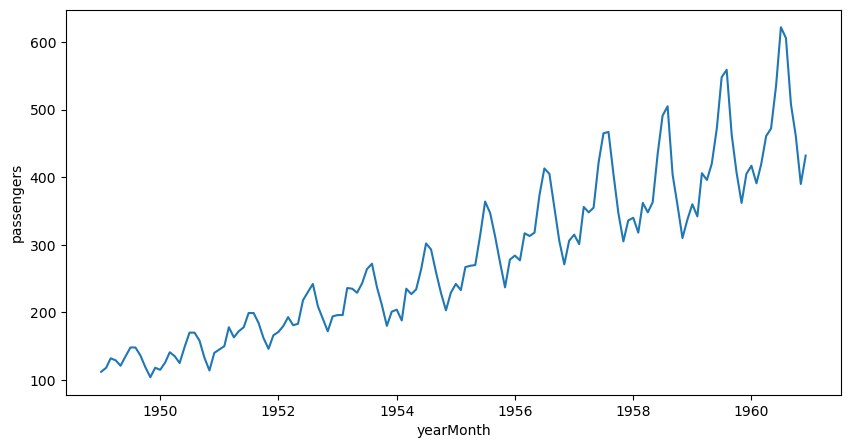

In [11]:
plt.figure(figsize = (10,5))
sns.lineplot(df, x = df.index, y = df.passengers)
plt.show()

In [12]:
df['rollMean'] = df['passengers'].rolling(window = 12 ).mean()
df['rollStd'] = df['passengers'].rolling(window = 12 ).std()

<Axes: xlabel='yearMonth', ylabel='passengers'>

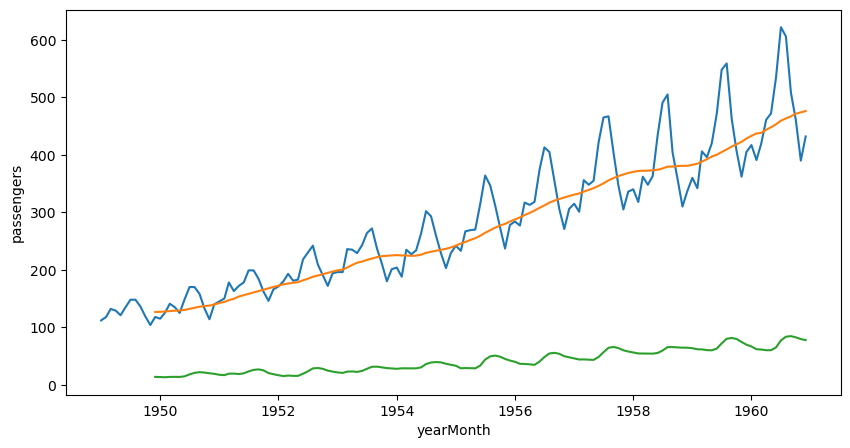

In [13]:
plt.figure(figsize = (10,5))
sns.lineplot(data = df , x = df.index, y = df.passengers)
sns.lineplot(data = df , x = df.index, y = df.rollMean)
sns.lineplot(data = df , x = df.index, y = df.rollStd)

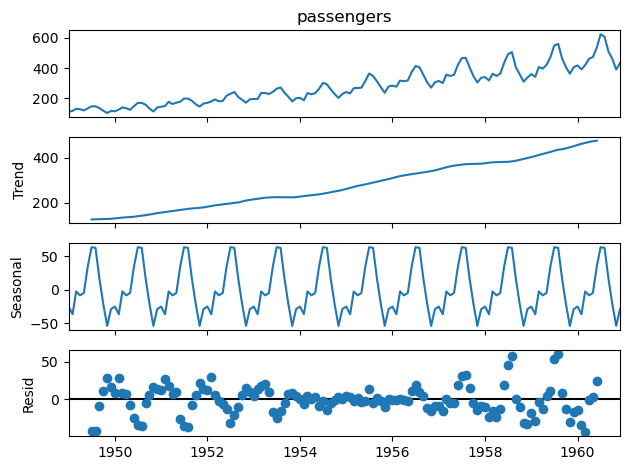

In [139]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df.passengers, period = 12)

fig = decomposition.plot()

In [14]:
# conclusion is that the our data is not statonary as our mean in not stationary


# now let's do it mathematically too using ADF test
from statsmodels.tsa.stattools import adfuller
adfTest = adfuller(df['passengers'])
print(adfTest) # lets interpret these valuess by ocnveting them to series
print("--------------------------------------------------------------------------------------------------------")

stats = pd.Series(adfTest[0:4], index = ['Test Statistic', 'p-value', '#lags used', 'number of observation used'])
print(stats)
# H0= Time Series is not stationary
# p-value>= 0.05 : Do not reject the null hypothesis
# ADF statistic is less negative (or more positive) than the critical value
# Do not reject the null hypothesis, meaning the series is non-stationary

(0.8153688792060547, 0.9918802434376411, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.692930839019)
--------------------------------------------------------------------------------------------------------
Test Statistic                  0.815369
p-value                         0.991880
#lags used                     13.000000
number of observation used    130.000000
dtype: float64


In [15]:
for key, values in adfTest[4].items():
    print('criticality',key,":",values)

criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


In [16]:
# We will see that our Test Statistics > Critical value in all the case, so we do not reject the null hypothesis. It means that our data is not stationary.

#### time shifting


In [18]:
def test_stationarity(dataFrame, var):
#     air_df.loc[:, 'rollMean'] = air_df['shiftDiff'].rolling(window=12).mean()
# air_df.loc[:, 'rollStd'] = air_df['shiftDiff'].rolling(window=12).std()

    dataFrame.loc[:, 'rollMean'] = dataFrame[var].rolling(window = 12).mean()
    dataFrame.loc[:, 'rollStd'] = dataFrame[var].rolling(window = 12).std()

    from statsmodels.tsa.stattools import adfuller
    adfTest = adfuller(dataFrame[var])
    stats = pd.Series(adfTest[0:4], index = ['Test Statistic', 'p-value', '#lags used', 'number of observation used'])
    print(stats)

    for key, values in adfTest[4].items():
        print('criticality',key,":",values)

    sns.lineplot(data = dataFrame, x = dataFrame.index, y = var)
    sns.lineplot(data = dataFrame, x = dataFrame.index, y = 'rollMean')
    sns.lineplot(data = dataFrame, x = dataFrame.index, y = 'rollStd')
    plt.show()

In [19]:
# just get the passengers column nito a dataframe for easier testing
air_df = df[['passengers']].copy(deep = True) # double bracket because it is a list within a list
print(air_df.head())

            passengers
yearMonth             
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


                     passengers  shift  shiftDiff
yearMonth                                        
1949-01-01 00:00:00       112.0    NaN        NaN
1949-02-01 00:00:00       118.0  112.0        6.0
1949-03-01 00:00:00       132.0  118.0       14.0
1949-04-01 00:00:00       129.0  132.0       -3.0
1949-05-01 00:00:00       121.0  129.0       -8.0
1949-06-01 00:00:00       135.0  121.0       14.0
1949-07-01 00:00:00       148.0  135.0       13.0
1949-08-01 00:00:00       148.0  148.0        0.0
1949-09-01 00:00:00       136.0  148.0      -12.0
1949-10-01 00:00:00       119.0  136.0      -17.0
1949-11-01 00:00:00       104.0  119.0      -15.0
1949-12-01 00:00:00       118.0  104.0       14.0
1950-01-01 00:00:00       115.0  118.0       -3.0
1950-02-01 00:00:00       126.0  115.0       11.0
1950-03-01 00:00:00       141.0  126.0       15.0
1950-04-01 00:00:00       135.0  141.0       -6.0
1950-05-01 00:00:00       125.0  135.0      -10.0
1950-06-01 00:00:00       149.0  125.0       24.0


C:\Users\DAI.STUDENTSDC\AppData\Local\Temp\ipykernel_13880\15005377.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame.loc[:, 'rollMean'] = dataFrame[var].rolling(window = 12).mean()
C:\Users\DAI.STUDENTSDC\AppData\Local\Temp\ipykernel_13880\15005377.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame.loc[:, 'rollStd'] = dataFrame[var].rolling(window = 12).std()


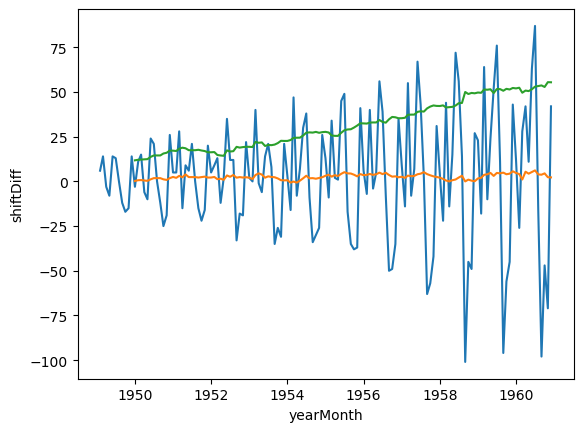

In [87]:
# create a new column which will contain the shifted value from the passenger column
air_df['shift'] = air_df.passengers.shift(1)
air_df['shiftDiff'] = air_df['passengers'] - air_df['shift']
print(air_df.head(20))

test_stationarity(air_df.dropna(), 'shiftDiff')
# p-value is just close to 0.05, so let us try a shift of 2


                     passengers  shift  shiftDiff
yearMonth                                        
1949-01-01 00:00:00       112.0    NaN        NaN
1949-02-01 00:00:00       118.0    NaN        NaN
1949-03-01 00:00:00       132.0  112.0       20.0
1949-04-01 00:00:00       129.0  118.0       11.0
1949-05-01 00:00:00       121.0  132.0      -11.0
1949-06-01 00:00:00       135.0  129.0        6.0
1949-07-01 00:00:00       148.0  121.0       27.0
1949-08-01 00:00:00       148.0  135.0       13.0
1949-09-01 00:00:00       136.0  148.0      -12.0
1949-10-01 00:00:00       119.0  148.0      -29.0
1949-11-01 00:00:00       104.0  136.0      -32.0
1949-12-01 00:00:00       118.0  119.0       -1.0
1950-01-01 00:00:00       115.0  104.0       11.0
1950-02-01 00:00:00       126.0  118.0        8.0
1950-03-01 00:00:00       141.0  115.0       26.0
1950-04-01 00:00:00       135.0  126.0        9.0
1950-05-01 00:00:00       125.0  141.0      -16.0
1950-06-01 00:00:00       149.0  135.0       14.0


C:\Users\DAI.STUDENTSDC\AppData\Local\Temp\ipykernel_13880\15005377.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame.loc[:, 'rollMean'] = dataFrame[var].rolling(window = 12).mean()
C:\Users\DAI.STUDENTSDC\AppData\Local\Temp\ipykernel_13880\15005377.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame.loc[:, 'rollStd'] = dataFrame[var].rolling(window = 12).std()


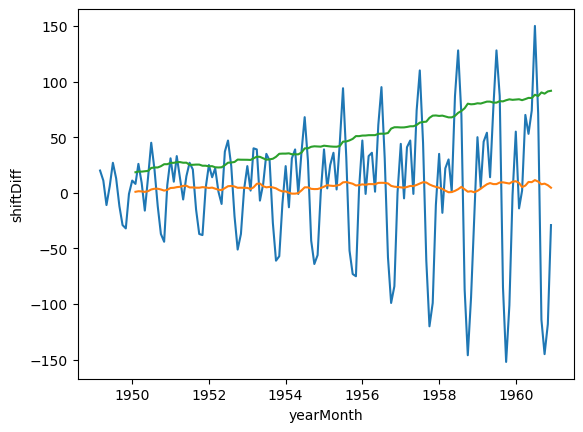

In [93]:
# create a new column which will contain the shifted value from the passenger column
air_df['shift'] = air_df.passengers.shift(2)
air_df['shiftDiff'] = air_df['passengers'] - air_df['shift']
print(air_df.head(20))

test_stationarity(air_df.dropna(), 'shiftDiff')
#p-value = 0.3, which is < 0.05, so,
# Conclusion: The data has become somewhat stationary

### arima

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [24]:
airP = df[['passengers']].copy(deep = True)
airP['firstDiff'] = airP['passengers'].diff()
airP['Diff12'] = airP['passengers'].diff(12) # this will be used in sarimax

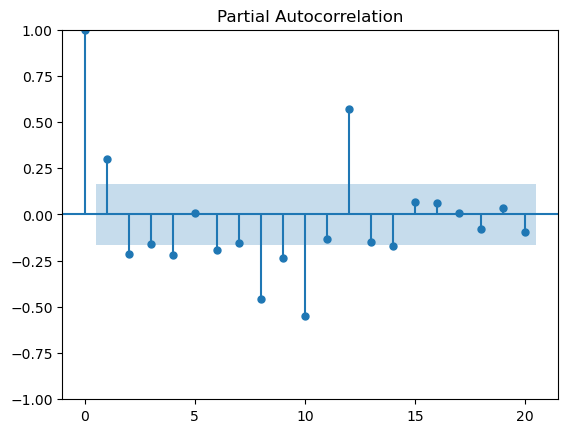

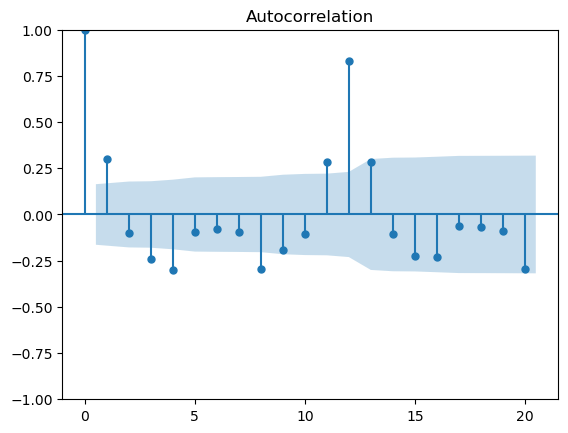

In [25]:
plot_pacf(airP['firstDiff'].dropna(), lags = 20)
plt.show()
plot_acf(airP['firstDiff'].dropna(), lags = 20)
plt.show()


In [26]:
# build ARIMA model
train = airP[:round(len(airP)*70/100)] # take the first 70% data
print(train.tail())

            passengers  firstDiff  Diff12
yearMonth                                
1957-01-01         315        9.0    31.0
1957-02-01         301      -14.0    24.0
1957-03-01         356       55.0    39.0
1957-04-01         348       -8.0    35.0
1957-05-01         355        7.0    37.0


In [27]:
test = airP[round(len(airP)*70/100):]
print(test.head())

            passengers  firstDiff  Diff12
yearMonth                                
1957-06-01         422       67.0    48.0
1957-07-01         465       43.0    52.0
1957-08-01         467        2.0    62.0
1957-09-01         404      -63.0    49.0
1957-10-01         347      -57.0    41.0


            passengers  firstDiff  Diff12   arimaPred
yearMonth                                            
1960-08-01         606      -16.0    47.0  451.948123
1960-09-01         508      -98.0    45.0  454.401429
1960-10-01         461      -47.0    54.0  456.854734
1960-11-01         390      -71.0    28.0  459.308040
1960-12-01         432       42.0    27.0  461.761345


C:\Users\DAI.STUDENTSDC\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DAI.STUDENTSDC\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DAI.STUDENTSDC\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='yearMonth', ylabel='arimaPred'>

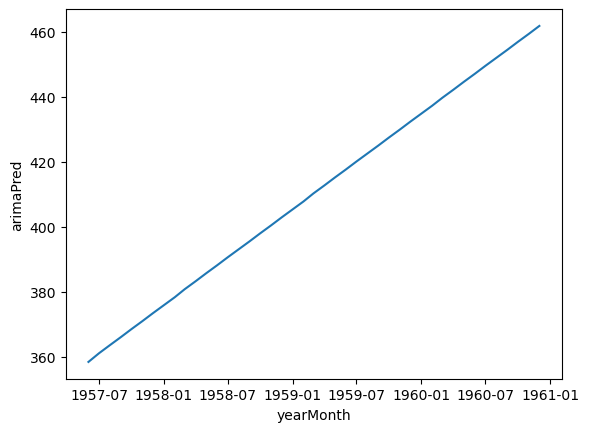

In [101]:
model = ARIMA(train['passengers'], order = (1,2,1)) # p, d, q
model_fit = model.fit()
prediction = model_fit.predict(start = test.index[0], end = test.index[-1])
airP['arimaPred'] = prediction
print(airP.tail())
sns.lineplot(data = airP, x = airP.index, y = 'arimaPred')

In [103]:
#### sarimax

In [111]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['passengers'], order = (1, 2, 1), seasonal_order = (1, 2, 1, 12))
model_fit = model.fit()
prediction = model_fit.predict(start = test.index[0], end = test.index[-1])
airP['sarimaxPred'] = prediction
print(airP.tail())
# data looks beter

C:\Users\DAI.STUDENTSDC\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DAI.STUDENTSDC\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            passengers  firstDiff  Diff12   arimaPred  sarimaxPred
yearMonth                                                         
1960-08-01         606      -16.0    47.0  451.948123   588.726547
1960-09-01         508      -98.0    45.0  454.401429   518.337264
1960-10-01         461      -47.0    54.0  456.854734   452.559438
1960-11-01         390      -71.0    28.0  459.308040   402.779885
1960-12-01         432       42.0    27.0  461.761345   450.755451


            passengers  firstDiff  Diff12  arimaPred  sarimaxPred
yearMonth                                                        
1949-01-01         112        NaN     NaN        NaN          NaN
1949-02-01         118        6.0     NaN        NaN          NaN
1949-03-01         132       14.0     NaN        NaN          NaN
1949-04-01         129       -3.0     NaN        NaN          NaN
1949-05-01         121       -8.0     NaN        NaN          NaN


<Axes: xlabel='yearMonth', ylabel='passengers'>

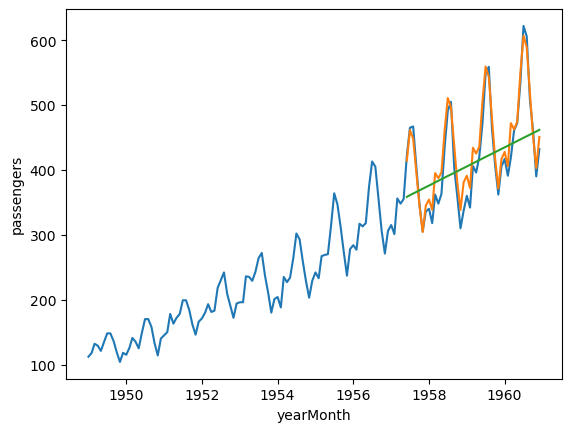

In [113]:
airP.dropna()
print(airP.head())
sns.lineplot(data = airP, x = airP.index, y = 'passengers')
sns.lineplot(data = airP, x = airP.index, y = 'sarimaxPred')
sns.lineplot(data = airP, x = airP.index, y = 'arimaPred')

In [115]:
#compared to arima , sarimax is much better 
# future prediction first check the last date in our datset
print(airP.tail())

            passengers  firstDiff  Diff12   arimaPred  sarimaxPred
yearMonth                                                         
1960-08-01         606      -16.0    47.0  451.948123   588.726547
1960-09-01         508      -98.0    45.0  454.401429   518.337264
1960-10-01         461      -47.0    54.0  456.854734   452.559438
1960-11-01         390      -71.0    28.0  459.308040   402.779885
1960-12-01         432       42.0    27.0  461.761345   450.755451


In [125]:
#MS: month start frequency
# create dataframe to hold indeec values form 01-01-61 to --------61
futureDate = pd.DataFrame(pd.date_range(start = '1961-01-01', end = '1963-01-01', freq = 'MS'), columns = ['Dates'])
futureDate.set_index('Dates', inplace = True)
print(futureDate.head())

Empty DataFrame
Columns: []
Index: [1961-01-01 00:00:00, 1961-02-01 00:00:00, 1961-03-01 00:00:00, 1961-04-01 00:00:00, 1961-05-01 00:00:00]


1961-01-01    462.520429
1961-02-01    437.510284
1961-03-01    508.309257
1961-04-01    497.686178
1961-05-01    510.988031
1961-06-01    591.629112
1961-07-01    652.282661
1961-08-01    631.977321
1961-09-01    555.794849
1961-10-01    485.292074
1961-11-01    431.938781
1961-12-01    482.499552
1962-01-01    494.900354
1962-02-01    466.739858
1962-03-01    541.889791
1962-04-01    530.260293
1962-05-01    544.983812
1962-06-01    630.668469
1962-07-01    694.773172
1962-08-01    672.324835
1962-09-01    590.249489
1962-10-01    514.932337
1962-11-01    457.956298
1962-12-01    511.004895
1963-01-01    523.981562
Freq: MS, Name: predicted_mean, dtype: float64


<Axes: xlabel='yearMonth', ylabel='passengers'>

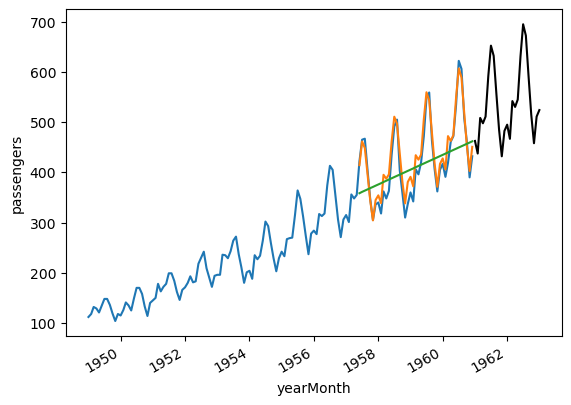

In [127]:
#predict and print
print(model_fit.predict(start = futureDate.index[0], end = futureDate.index[-1]))

#plot
airP.dropna()
sns.lineplot(data = airP, x= airP.index, y = 'passengers')
sns.lineplot(data = airP, x= airP.index, y = 'sarimaxPred')
sns.lineplot(data = airP, x= airP.index, y = 'arimaPred')
model_fit.predict(start = futureDate.index[0], end = futureDate.index[-1]).plot(color = 'k')

## chi-Square TEst

In [164]:
from scipy.stats import chi2_contingency

df = pd.read_csv('airline_passenger_satisfaction.csv')
male_df = df[df['Gender'] == 'Male'] #Filter by Gender

In [175]:
# Analyze on board service  and class(Independence TEst - male passenger)
category1 = 'Class'
category2 = 'On-board Service'

# performin contngency
crosstab = pd.crosstab(male_df[category1], male_df[category2])

# perform chi square test
chi2, pval, degrees_of_freedom, expected_counts = chi2_contingency(crosstab)


 
# print results
print(f'\nCategory 1: {category1}, category 2 : {category2} (male passengers)')
print(crosstab)
print(f"Chi-square: {chi2:.2f}, p-value: {pval:.4f}, Degree of Freedom: {degrees_of_freedom}")

# interpretation
if pval < 0.05:
    print("Reject null hypothesis: There's a significant association between class and on-board service rating (p < 0.05).")
else:
    print("Fail to reject null hypothesis : Class and on-board service rating might be independent(p>=0.05).")


Category 1: Class, category 2 : On-board Service (male passengers)
On-board Service  0     1     2     3      4     5
Class                                             
Business          2  2053  3379  5826  10743  8894
Economy           0  4420  4430  7403   7535  4851
Economy Plus      0   791   792  1118   1076   668
Chi-square: 3277.66, p-value: 0.0000, Degree of Freedom: 10
Reject null hypothesis: There's a significant association between class and on-board service rating (p < 0.05).
